# Answer to question3(a). Predict the amount of loan that can be given.

#### The below approach is just my intuition of how this question can be solved. Since there was no information on any treshold for granting of loans, I have built this regression model. 

#### This model is built on only those obsevations where the company has granted the loan. Say the first model that we built says that the customer is not eligible for any kind of loan due to his initial selection, this model can then tell us how much amount we can offer according to his inputs

In [1]:
from azureml import Workspace

ws = Workspace()
ds = ws.datasets['processed-loan.csv']
df = ds.to_dataframe()

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


In [4]:
df['Loan_Status'].value_counts()

Y    422
Name: Loan_Status, dtype: int64

In [5]:
df.shape

(422, 13)

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,422.0,5384.068720,5765.441615,210.0,2877.5,3812.5,5771.50,63337.0
CoapplicantIncome,422.0,1504.516398,1924.754855,0.0,0.0,1239.5,2297.25,20000.0
LoanAmount,411.0,144.294404,85.484607,17.0,100.0,126.0,161.00,700.0
Loan_Amount_Term,414.0,341.072464,63.247770,12.0,360.0,360.0,360.00,480.0
Credit_History,385.0,0.981818,0.133782,0.0,1.0,1.0,1.00,1.0


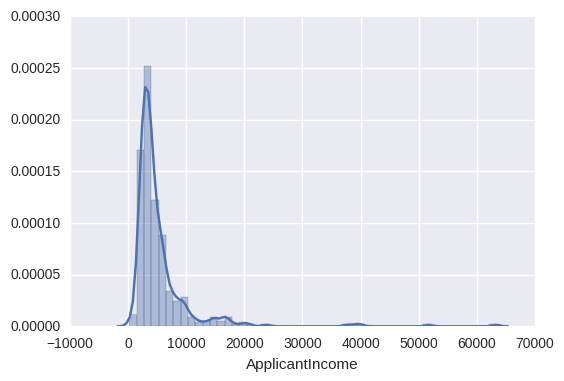

In [7]:
# Lets start with univariate analysis
sns.distplot(df.ApplicantIncome,kde=True)

In [8]:
# we can merge Applicant income and co-applicant income into one as total imcome. 

df['TotalIncome']= df['ApplicantIncome'] +df['CoapplicantIncome'] 

# Since there are alot of outliers here, we will take the log value to reduce the effect 

df['TotalIncome']=np.log(df['TotalIncome'])

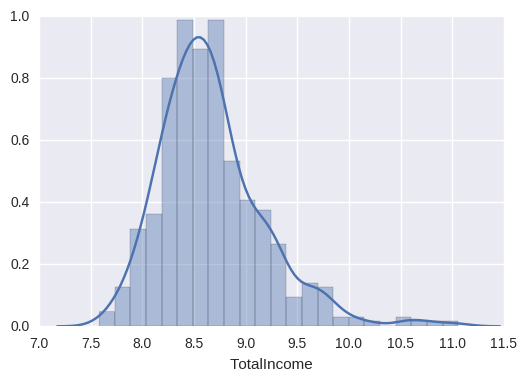

In [9]:
sns.distplot(df.TotalIncome,kde=True) # Its more or less a guassian distribution now. 

In [10]:
# Lets drop the columns that we dont need now. 
df.drop(['Loan_ID','ApplicantIncome','CoapplicantIncome','Loan_Status'], axis=1,inplace = True)

In [11]:
df.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
       'TotalIncome'],
      dtype='object')

In [12]:
df.isnull().sum()

Gender               8
Married              3
Dependents           9
Education            0
Self_Employed       23
LoanAmount          11
Loan_Amount_Term     8
Credit_History      37
Property_Area        0
TotalIncome          0
dtype: int64

In [13]:
# We will have to handle missing values the same way we did in the other questions. 

#categorical
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)
#numerical
df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)

In [14]:
df.isnull().sum()

Gender              0
Married             0
Dependents          0
Education           0
Self_Employed       0
LoanAmount          0
Loan_Amount_Term    0
Credit_History      0
Property_Area       0
TotalIncome         0
dtype: int64

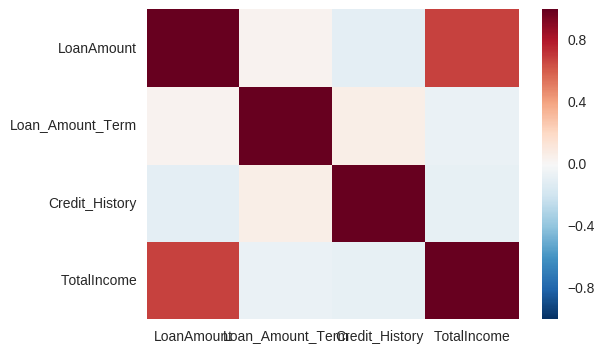

In [15]:
sns.heatmap(df.corr()) # Bivariate analysis. We see that total income and loan amount has some relationship. 

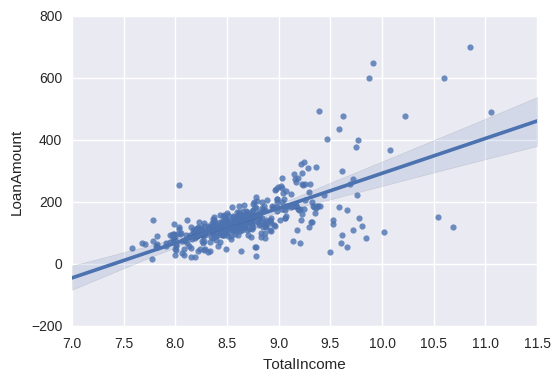

In [16]:
sns.regplot(x=df.TotalIncome,y=df.LoanAmount,data=df) # We see that there is a positive linear relationship. 

In [17]:
# Lets encode the categorical values

from sklearn.preprocessing import LabelEncoder
category = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area'] 
encoder = LabelEncoder()
for i in category:
  df[i] = encoder.fit_transform(df[i])
df.dtypes

Gender                int64
Married               int64
Dependents            int64
Education             int64
Self_Employed         int64
LoanAmount          float64
Loan_Amount_Term    float64
Credit_History      float64
Property_Area         int64
TotalIncome         float64
dtype: object

In [18]:
y = df.pop('LoanAmount')

In [19]:
x = df

In [20]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=12347)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((337, 9), (85, 9), (337,), (85,))

In [21]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [22]:
lr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
yhat = lr.predict(x_test)

In [24]:
from sklearn.metrics import r2_score
score = r2_score(y_test,yhat)
score

0.50918461776863433

In [25]:
lr.intercept_

-771.88128919053906

In [26]:
lr.coef_

array([  4.82300879,   9.71404037,   7.56000677,  -7.55806269,
         4.41347848,   0.14770813,  11.8555838 ,  -0.77517667,  96.44789263])

In [32]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test,yhat))

5595.34543579


In [37]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
x_train_scaled = scale.fit(x_train).transform(x_train)
x_test_scaled = scale.fit(x_test).transform(x_test)

In [38]:
lr.fit(x_train_scaled,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [39]:
yhat2 = lr.predict(x_test_scaled)

In [43]:
print(mean_squared_error(y_test,yhat2))
print(r2_score(y_test,yhat2))


5929.44851416
0.479877592493


In [42]:
def rmse(predictions, targets): 
    return np.sqrt(((predictions - targets) ** 2).mean())

In [44]:
print(rmse(yhat2,y_test))

77.0029123745


In [46]:
!pip install lightgbm

    100% |ââââââââââââââââââââââââââââââââ| 1.2MB 843kB/s eta 0:00:01
You are using pip version 19.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [47]:
from lightgbm import LGBMRegressor

In [49]:
reg = LGBMRegressor()

In [50]:
reg.fit(x_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [51]:
yhat1 = reg.predict(x_test)

In [53]:
print(rmse(yhat1,y_test))
print(r2_score(yhat1,y_test))
print(mean_squared_error(yhat1,y_test))

78.8724023329
-0.838088024055
6220.85584976


In [61]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'min_child_weight': [1e-5,1, 1e3, 1e4],
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1, 2, 5, 7, 10],
             'reg_lambda': [0, 1, 5, 10, 100]}

In [62]:
regressor = LGBMRegressor(max_depth=-1, random_state=314, silent=True, metric='root_mean_scored_error', n_jobs=4, n_estimators=5000)
n_HP_points_to_test = 100
from sklearn.model_selection import RandomizedSearchCV
gs = RandomizedSearchCV(
    estimator=regressor, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [63]:
gs.fit(x_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  6.7min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       metric='root_mean_scored_error', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
       n_jobs=4, num_leaves=31, objective=None, random_state=314,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0),
          fit_params={}, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'min_child_weight': [1e-05, 1, 1000.0, 10000.0], 'reg_alpha': [0, 1, 2, 5, 7, 10], 'reg_lambda': [0, 1, 5, 10, 100], 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb322f16dd8>},
          pre_dispatch='2*n_jobs', random_state=314, refit=True,
          return_train_score=True, scoring=None, verbose=True)

In [64]:
gs.best_score_

0.1321371909964395

In [65]:
gs.best_params_

{'colsample_bytree': 0.42875980097754329,
 'min_child_weight': 1e-05,
 'reg_alpha': 7,
 'reg_lambda': 100}

In [66]:
reg1 = LGBMRegressor(colsample_bytree=0.42875980097754329,min_child_weight=1e-05,reg_alpha=7,reg_lambda=100)

In [67]:
reg1.fit(x_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None,
       colsample_bytree=0.4287598009775433, importance_type='split',
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=1e-05, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=7, reg_lambda=100, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [68]:
gs_yhat = reg1.predict(x_test)

In [70]:
reg1.score(x_train,y_train)

0.39704883897145576

In [71]:
reg1.score(x_test,y_test)

0.35950258656771328

In [73]:
print(rmse(gs_yhat,y_test))
print(r2_score(gs_yhat,y_test))

85.4501952232
-2.83261439813
